In [2]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
import re
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch import nn
import segmentation_models_pytorch.utils as smpu
import segmentation_models_pytorch

%matplotlib inline

/home/tim/anaconda3/envs/spinalseg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
subjects = []

single_imgs = Path(op.join(sys.path[0], 'dataset/Experiment4/sub-02/single_images'))
regex = re.compile(r'\d+')

for file in single_imgs.iterdir():
    idx = int(regex.findall(str(file))[2])
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'dataset/Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], 'dataset/Experiment4/sub-02/mask_sc.nii.gz')
        
    subjects.append(tio.Subject(img=tio.ScalarImage(file), label=tio.LabelMap(label_path),
                                num=idx, shape=[tio.ScalarImage(file).shape]))

In [13]:
dataset = tio.SubjectsDataset(subjects, transform=tio.CropOrPad((160, 64, 64),))

In [4]:
# split into 60 / 20 / 20
set_split = 0.2
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(set_split * dataset_size))
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

NameError: name 'val_indices' is not defined

In [231]:
test = Subset(dataset, train_indices)

In [6]:
len(test)/0.8*0.2

72.0

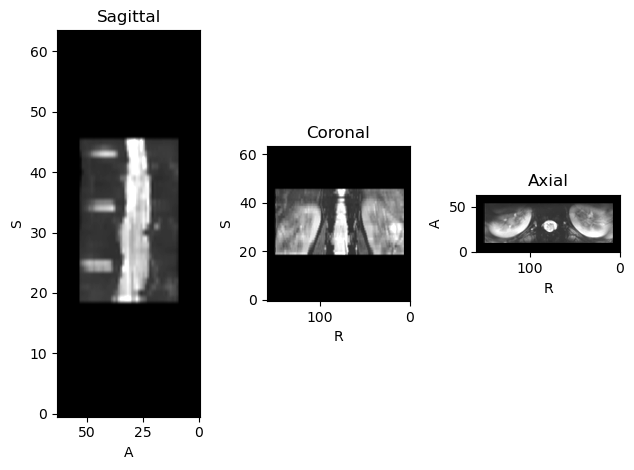

In [232]:
dataset[0].img.plot()

In [5]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter


# adaptions made to the classes from segmentation models
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True, unet2d=False):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

        self.unet2d = unet2d

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
                dataloader,
                desc=self.stage_name,
                file=sys.stdout,
                disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                x = data['img']['data']
                y = data['label']['data']
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True, unet2d=False):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
            unet2d=unet2d
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        if self.unet2d is True:
            batch_size = x.shape[0]
            o_shape = x.shape
            x = x.reshape(batch_size, 1, 160, -1)

            prediction = self.model.forward(x).reshape(o_shape)
        else:
            prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True, unet2d=False):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
            unet2d=unet2d
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            if self.unet2d is True:
                batch_size = x.shape[0]
                o_shape = x.shape
                x = x.reshape(batch_size, 1, 160, -1)

                prediction = self.model.forward(x).reshape(o_shape)
            else:
                prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction


In [6]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        out = None
        if not self.bottleneck:
            out = self.pooling(x)
        else:
            out = x
        return out, x

class UpConv3DBlock(nn.Module):

    def __init__(self, in_channels, res_channels=0, last_layer=False, out_channels=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and out_channels==None) or (last_layer==True and out_channels!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=out_channels, kernel_size=(1,1,1))
            
        
    def forward(self, x, residual=None):
        out = self.upconv1(x)
        if residual != None:
            out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer:
            out = self.conv3(out)
        return out
        



class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, lvl_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        lvl_1_chnls, lvl_2_chnls, lvl_3_chnls = lvl_channels[0], lvl_channels[1], lvl_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=lvl_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=lvl_1_chnls, out_channels=lvl_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=lvl_2_chnls, out_channels=lvl_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=lvl_3_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block3 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=lvl_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=lvl_3_chnls, res_channels=lvl_2_chnls)
        self.s_block1 BatchNorm3d= UpConv3DBlock(in_channels=lvl_2_chnls, res_channels=lvl_1_chnls, out_channels=out_channels, last_layer=True)

    
    def forward(self, x):
        # Left path
        out, residual_lvl1 = self.a_block1(x)
        out, residual_lvl2 = self.a_block2(out)
        out, residual_lvl3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)

        # Right path
        out = self.s_block3(out, residual_lvl3)
        out = self.s_block2(out, residual_lvl2)
        out = self.s_block1(out, residual_lvl1)
        return out

class small3unet(nn.Module):
    def __init__(self, in_channels, out_channels, lvl_channels=[64, 128], bottleneck_channel=256) -> None:
        super(small3unet, self).__init__()
        lvl_1_chnls, lvl_2_chnls = lvl_channels[0], lvl_channels[1]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=lvl_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=lvl_1_chnls, out_channels=lvl_2_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=lvl_2_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block2 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=lvl_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=lvl_2_chnls, res_channels=lvl_1_chnls, out_channels=out_channels, last_layer=True)

    
    def forward(self, x):
        # Left path
        out, residual_lvl1 = self.a_block1(x)
        out, residual_lvl2 = self.a_block2(out)
        out, _ = self.bottleNeck(out)

        # Right path
        out = self.s_block2(out, residual_lvl2)
        out = self.s_block1(out, residual_lvl1)
        return out

SyntaxError: invalid syntax (4181350991.py, line 63)

In [7]:
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

class VolDiceLoss(nn.Module):
    __name__ = "dice_loss"
    
    def __init__(self, normalization='sigmoid'):
        super(VolDiceLoss, self).__init__()
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, y, pred, epsilon=1e-6):
        """
        Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
        Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
        Args:
             y (torch.Tensor): NxCxSpatial input tensor
             pred (torch.Tensor): NxCxSpatial target tensor
             epsilon (float): prevents division by zero
        """

        # input and target shapes must match
        assert y.size() == pred.size(), "'input' and 'target' must have the same shape"

        y = flatten(y)
        pred = flatten(pred)
        y = y.float()

        # compute per channel Dice Coefficient
        intersect = (y * pred).sum(-1)

        # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
        denominator = (y * y).sum(-1) + (pred * pred).sum(-1)
        return 2 * (intersect / denominator.clamp(min=epsilon))

    def forward(self, pred, y):
        # get probabilities from logits
        pred = self.normalization(pred)

        # compute per channel Dice coefficient
        dice = self.dice(y, pred)
        
        # average Dice score across all channels/classes
        return 1. - dice[0]
    
class JaccardIndex(nn.Module):
    __name__ = "iou_score"
    
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, pred, y):
        n_classes = pred.size()[1]
        assert pred.size() == y.size()

        per_batch_iou = []
        for _input, _target in zip(pred, y):
            binary_prediction = self._binarize_predictions(_input, n_classes)

            # convert to uint8 just in case
            binary_prediction = binary_prediction.byte()
            _target = _target.byte()

            per_channel_iou = []
            for c in range(n_classes):
                per_channel_iou.append(self._jaccard_index(binary_prediction[c], _target[c]))

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.mean(torch.tensor(per_channel_iou))
            per_batch_iou.append(mean_iou)

        return torch.mean(torch.tensor(per_batch_iou))

    def _binarize_predictions(self, y, n_classes):
        """
        Puts 1 for the class/channel with the highest probability and 0 in other channels. Returns byte tensor of the
        same size as the input tensor.
        """
        if n_classes == 1:
            # for single channel input just threshold the probability map
            result = y > 0.5
            return result.long()

        _, max_index = torch.max(y, dim=0, keepdim=True)
        return torch.zeros_like(y, dtype=torch.uint8).scatter_(0, max_index, 1)

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        return torch.sum(prediction & target).float() / torch.clamp(torch.sum(prediction | target).float(), min=1e-8)

In [17]:
#loss = VolDiceLoss()
metrics = [JaccardIndex()]
# loss.__name__ = 'dice_loss'
# model = small3unet(1, 1)
model = VNet()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])

train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=torch.device('cpu'),
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=torch.device('cpu'),
    verbose=True,
)

In [18]:
new_dataset = Subset(dataset, [0, 1])
n_dat = Subset(dataset, [0, 1])

In [19]:
train_loader = DataLoader(new_dataset, batch_size=1)
val_loader = DataLoader(n_dat, batch_size=1)

In [20]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
for epoch in range(160):
    print('\nEpoch: {}/{}'.format(epoch + 1, 10))
        
    train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(val_loader)
        
    train_loss = train_logs['dice_loss']
    train_acc = train_logs['iou_score']
#     val_loss = valid_logs['dice_loss']
#     val_acc = valid_logs['iou_score']
        
    history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
#     history['val_acc'].append(val_acc)


Epoch: 1/10
train: 100%|█| 2/2 [00:14<00:00,  7.38s/it, dice_loss - 0.9849, iou_score - 0.01

Epoch: 2/10
train: 100%|█| 2/2 [00:14<00:00,  7.43s/it, dice_loss - 0.9773, iou_score - 0.01

Epoch: 3/10
train: 100%|█| 2/2 [00:15<00:00,  7.59s/it, dice_loss - 0.9715, iou_score - 0.02

Epoch: 4/10
train: 100%|█| 2/2 [00:14<00:00,  7.45s/it, dice_loss - 0.9631, iou_score - 0.03

Epoch: 5/10
train: 100%|█| 2/2 [00:14<00:00,  7.48s/it, dice_loss - 0.951, iou_score - 0.045

Epoch: 6/10
train: 100%|█| 2/2 [00:14<00:00,  7.49s/it, dice_loss - 0.9327, iou_score - 0.08

Epoch: 7/10
train: 100%|█| 2/2 [00:14<00:00,  7.43s/it, dice_loss - 0.9098, iou_score - 0.10

Epoch: 8/10
train: 100%|█| 2/2 [00:15<00:00,  7.65s/it, dice_loss - 0.876, iou_score - 0.129

Epoch: 9/10
train: 100%|█| 2/2 [00:15<00:00,  7.55s/it, dice_loss - 0.8206, iou_score - 0.23

Epoch: 10/10
train: 100%|█| 2/2 [00:15<00:00,  7.55s/it, dice_loss - 0.7763, iou_score - 0.24

Epoch: 11/10
train: 100%|█| 2/2 [00:14<00:00,  7.41s/it, d

KeyboardInterrupt: 

In [9]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(np.swapaxes(image, 0, 1))
    plt.show()

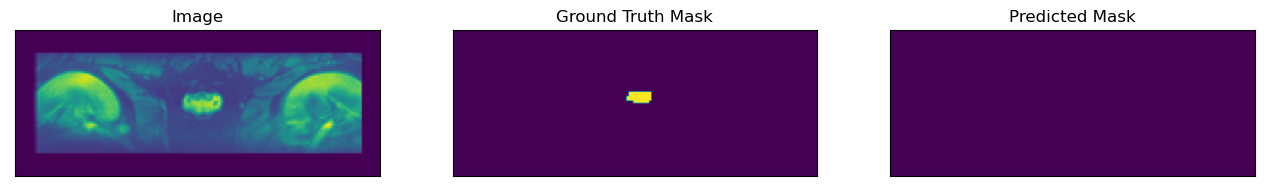

In [165]:
    
image_vis = dataset[0].img.data.reshape(160,64,48)
image, gt_mask = dataset[0].img.data, dataset[0].label.data
    
gt_mask = gt_mask.reshape(160,64,48)
    
x_tensor = image.unsqueeze(0)
model.eval()
pr_mask = model.forward(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160,64,48)
#     pr_mask[pr_mask < value] = 0
#     pr_mask[pr_mask > value] = 1
        
visualize(
    image=image_vis[:,:,12], 
    ground_truth_mask=gt_mask[:,:,12], 
    predicted_mask=pr_mask[:,:,12]
)

In [59]:
subjects = []
cop = tio.CropOrPad((160, 64, 35))

lumbar = Path(op.join(sys.path[0], 'dataset/Lumbar'))

for file_path in lumbar.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        image = tio.ScalarImage(image)
    for label in file_path.rglob('*sc.nii.gz'):
        label = tio.ScalarImage(label)
        
    subjects.append(tio.Subject(img=cop(image), label=cop(label), shape=[image.shape]))

In [60]:
dataset = tio.SubjectsDataset(subjects)

In [61]:
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [62]:
image_files[0].plot()

NameError: name 'image_files' is not defined

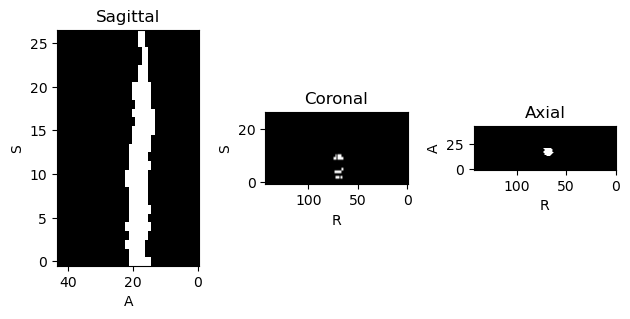

In [131]:
image_labels[0].plot()

In [132]:
created_model = torch.load('../../output3/k_cross.pth', map_location=torch.device('cpu'))

In [206]:
loss = smpu.losses.DiceLoss()
metrics = [
    smpu.metrics.IoU(threshold=0.5),
]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [154]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=True
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 16/16 [00:16<00:00,  1.04s/it, dice_loss - 0.4166, iou_score - 0.


In [179]:
logs

{'dice_loss': 0.4166391492850583, 'iou_score': 0.4257682879607017}

In [10]:
class InputLayerVNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(InputLayerVNet, self).__init__()
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels // 2, kernel_size=(5, 5, 5),
                              padding=2)
        self.relu = nn.PReLU()
        self.bn1 = nn.BatchNorm3d(out_channels // 2) # nn.GroupNorm(num_groups=4, num_channels=out_channels // 2)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.down_conv = nn.Conv3d(in_channels=out_channels // 2, out_channels=out_channels, kernel_size=(2, 2, 2),
                                   stride=2)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv(x)))
        res = torch.add(out, x)
        out = self.relu(self.bn2(self.down_conv(res)))
        return res, out


class EncodeBlockVNet1(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(EncodeBlockVNet1, self).__init__()
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm3d(in_channels) # nn.GroupNorm(num_groups=4, num_channels=in_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.down_conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2, 2),
                                   stride=2)
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.do(out)
        out = self.relu(self.bn(self.conv(out)))
        out = self.do(out)
        res = torch.add(out, x)
        out = self.relu(self.bn2(self.down_conv(res)))
        return res, out


class EncodeBlockVNet2(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bottleneck=False):
        super(EncodeBlockVNet2, self).__init__()
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm3d(in_channels) # nn.GroupNorm(num_groups=4, num_channels=in_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.down_conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2, 2),
                                   stride=2)
        self.up_conv = nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2, 2),
                                          stride=2)
        self.bottleneck = bottleneck
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.do(out)
        out = self.relu(self.bn(self.conv(out)))
        out = self.do(out)
        out = self.relu(self.bn(self.conv(out)))
        out = self.do(out)
        res = torch.add(out, x)
        if not self.bottleneck:
            out = self.relu(self.bn2(self.down_conv(res)))
            return res, out
        else:
            return self.relu(self.bn(self.up_conv(res)))


class DecodeBlockVnet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodeBlockVnet2, self).__init__()
        self.conv2 = nn.Conv3d(in_channels=int(in_channels * 1.5), out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm3d(in_channels) # nn.GroupNorm(num_groups=4, num_channels=in_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.up_conv = nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2, 2),
                                          stride=2)

    def forward(self, x, skip):
        out = torch.cat((x, skip), dim=1)
        out = self.relu(self.bn(self.conv2(out)))
        out = self.relu(self.bn(self.conv(out)))
        out = self.relu(self.bn(self.conv(out)))
        out = torch.add(out, x)
        out = self.bn2(self.up_conv(out))
        return out


class DecodeBlockVnet1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodeBlockVnet1, self).__init__()
        self.conv2 = nn.Conv3d(in_channels=int(in_channels * 1.5), out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm3d(in_channels) # nn.GroupNorm(num_groups=4, num_channels=in_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.up_conv = nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2, 2),
                                          stride=2)

    def forward(self, x, skip):
        out = torch.cat((x, skip), dim=1)
        out = self.relu(self.bn(self.conv2(out)))
        out = self.relu(self.bn(self.conv(out)))
        out = torch.add(out, x)
        out = self.bn2(self.up_conv(out))
        return out


class OutputLayerVnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputLayerVnet, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=int(in_channels * 1.5), out_channels=in_channels, kernel_size=(5, 5, 5), padding=2)
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm3d(in_channels) # nn.GroupNorm(num_groups=4, num_channels=in_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.activation = nn.Softmax(1)

    def forward(self, x, skip):
        out = torch.cat((x, skip), dim=1)
        out = self.relu(self.bn(self.conv1(out)))
        out = torch.add(out, x)
        out = self.bn2(self.conv2(out))
        out = out.permute(0, 2, 3, 4, 1).contiguous()
        out = out.view(out.numel() // 2, 2)
        out = self.activation(out)
        return out[:, 0]


class VNet(nn.Module):
    def __init__(self):
        super(VNet, self).__init__()
        self.encoder1 = InputLayerVNet(in_channels=1, out_channels=32)
        self.encoder2 = EncodeBlockVNet1(in_channels=32, out_channels=64)
        self.encoder3 = EncodeBlockVNet2(in_channels=64, out_channels=128)
        self.encoder4 = EncodeBlockVNet2(in_channels=128, out_channels=256)
        self.bottleneck = EncodeBlockVNet2(in_channels=256, out_channels=256, bottleneck=True)
        self.decoder4 = DecodeBlockVnet2(in_channels=256, out_channels=128)
        self.decoder3 = DecodeBlockVnet2(in_channels=128, out_channels=64)
        self.decoder2 = DecodeBlockVnet1(in_channels=64, out_channels=32)
        self.decoder1 = OutputLayerVnet(in_channels=32, out_channels=2)

    def forward(self, x):
        skip1, out = self.encoder1(x)
        skip2, out = self.encoder2(out)
        skip3, out = self.encoder3(out)
        skip4, out = self.encoder4(out)
        out = self.bottleneck(out)
        out = self.decoder4(out, skip4)
        out = self.decoder3(out, skip3)
        out = self.decoder2(out, skip2)
        out = self.decoder1(out, skip1)
        out = out.reshape(x.shape)
        return out

In [254]:
model = VNet()

In [147]:
model

VNet(
  (encoder1): InputLayerVNet(
    (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (relu): PReLU(num_parameters=1)
    (bn): GroupNorm(4, 32, eps=1e-05, affine=True)
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (encoder2): EncodeBlockVNet1(
    (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (relu): PReLU(num_parameters=1)
    (bn): GroupNorm(4, 32, eps=1e-05, affine=True)
    (down_conv): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (do): Dropout(p=0.3, inplace=False)
  )
  (encoder3): EncodeBlockVNet2(
    (conv): Conv3d(64, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (relu): PReLU(num_parameters=1)
    (bn): GroupNorm(4, 64, eps=1e-05, affine=True)
    (down_conv): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (up_conv): ConvTranspose3d(64, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (do): Dropout(p=0.3, inpla

In [324]:
list[torch.zeros(1, 3).size()]

list[1, 3]

In [471]:
path = "dataset/Experiment4/sub-02/mask_sc_vol2.nii.gz"

In [472]:
tio.ScalarImage(path)

ScalarImage(shape: (1, 144, 48, 30); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "dataset/Experiment4/sub-02/mask_sc_vol2.nii.gz")

In [527]:
import torch.nn.functional as F

In [547]:
from monai import losses

In [557]:
loss = FocalDiceLoss()

In [558]:
loss.__name__ = 'test'

In [556]:
class FocalDiceLoss(nn.Module):
    """
    https://www.sciencedirect.com/science/article/pii/S1361841521003042
    """
    def __init__(self, beta=3):
        super().__init__()
        self.beta = beta
        self.dice = VolDiceLoss()

    def forward(self, pred, target):
        focal_dice = 0.05 * self.dice(pred, target) ** (1 / self.beta) + 0.95 * (1 - self.dice(pred, target)) ** \
                        (1 / self.beta)
        return focal_dice

In [101]:
import segmentation_models_pytorch.losses as losses

In [124]:
loss = losses.DiceLoss('binary', from_logits = False,)

In [3]:
loss = smpu.losses.DiceLoss()